In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
import healpy as hp
from astropy.time import Time
from rubin_scheduler.scheduler.model_observatory import ModelObservatory, KinemModel
from rubin_scheduler.site_models import ConstantSeeingData, ConstantWindData

from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site
from rubin_scheduler.data import get_data_dir

In [2]:
at_usdf = False
if at_usdf:
    os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/group/rubin/shared/rubin_sim_data"
print("Using rubin_sim_data from ", get_data_dir())

Using rubin_sim_data from  /Users/lynnej/rubin_sim_data


In [3]:
# Setting the start of the *survey* (and keeping this the same) is important for the Model Observatory and Scheduler,
# because this sets an overall dither pattern per night, but also helps track things that may 
# otherwise change per night ... for SV surveys, might not be totally necessary, but is good practice
# (you can change the *day* / mjd that you are simulating, of course, but mjd_start should remain the same)

dayobs = '2024-09-09'

survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')

In [4]:
# Don't have to do this, but can grab almanac information

almanac = Almanac(mjd_start = survey_start.mjd)

def show_almanac_info(dayobs):
    night_info = almanac.get_sunset_info(evening_date=dayobs, longitude=Site('LSST').longitude_rad)
    
    dd = []
    for val, col in zip(night_info, night_info.dtype.names):
        if col == 'night':
            continue
        else:
            print(col, val, Time(val, format='mjd', scale='utc').iso)
    
    # And can check on the lunar phase -- this goes from 0 (new) to 100 (full)
    moon_phase = almanac.get_sun_moon_positions(night_info['moonrise'])['moon_phase']
    print(f'moonphase(%) {moon_phase.round(2)}')

show_almanac_info(dayobs)

sunset 60562.936555093154 2024-09-09 22:28:38.360
sun_n12_setting 60562.975207073614 2024-09-09 23:24:17.891
sun_n18_setting 60562.99454106344 2024-09-09 23:52:08.348
sun_n18_rising 60563.39397472935 2024-09-10 09:27:19.417
sun_n12_rising 60563.4132887749 2024-09-10 09:55:08.150
sunrise 60563.45188789442 2024-09-10 10:50:43.114
moonrise 60563.62073250674 2024-09-10 14:53:51.289
moonset 60563.19181374041 2024-09-10 04:36:12.707
moonphase(%) 46.25


In [5]:
def tma_movement(percent=70):
    # See https://confluence.lsstcorp.org/display/LSSTCOM/TMA+Motion+Settings
    # Expected performance at end of comcam on-sky is probably 10%
    if percent > 125:
        percent = 125
        print("Cannot exceed 125 percent, by requirements.")
    tma = {}
    scale = percent / 100.0
    tma['azimuth_maxspeed'] = np.min([10.0 * scale, 7.0])
    tma['azimuth_accel'] = 10.0 * scale
    tma['azimuth_jerk'] = np.max([1.0, 40.0 * scale])
    tma['altitude_maxspeed'] = 5.0 * scale
    tma['altitude_accel'] = 5.0 * scale
    tma['altitude_jerk'] = np.max([1.0, 20.0 * scale])
    tma['settle_time'] = 3.0
    return tma

In [6]:
def rotator_movement(percent=100):
    # Kevin and Brian say these can run 100% and are independent of TMA movement
    if percent > 125:
        percent = 125
        print("Cannot exceed 125 percent, by requirements.")
    rot = {}
    rot['maxspeed'] = 3.5 * percent/100
    rot['accel'] = 1.0 * percent/100
    rot['jerk'] = 4.0 * percent/100
    return rot

In [7]:
# MJD for start of simulation

night_info = almanac.get_sunset_info(evening_date=dayobs, longitude=Site('LSST').longitude_rad)
mjd_now = night_info['sunset']

# Set up model observatory with modified telescope movement and seeing

filterlist = ['g', 'r', 'i', ] # starting filter list -- set to whichever three filters are available? 
kinematic_model = KinemModel(mjd0=mjd_now)
kinematic_model.setup_camera(readtime=2.4, **rotator_movement(100.))
kinematic_model.setup_telescope(**tma_movement(10.0))
kinematic_model.mount_filters(filterlist)  # optional, but might be useful with comcam - must be last

# Some weather telemetry that might be useful
seeing_data = ConstantSeeingData(fwhm_500=2.0)
wind_data = ConstantWindData(wind_direction=340, wind_speed=5.0)

# Set up the model observatory
observatory = ModelObservatory(mjd=mjd_now, 
                               mjd_start=survey_start.mjd,
                               kinem_model=kinematic_model, # Modified kinematics
                               cloud_data='ideal',          # No clouds
                               seeing_data=seeing_data,     # Modified seeing
                               wind_data=wind_data,         # Add some wind
                               downtimes='ideal',           # No downtime
                               lax_dome=True,               # dome crawl?
                               init_load_length=2,          # size of skybrightness files to load first
                              )

In [8]:
# So you can see the state of the model observatory at any time .. 
# Note that changing the time here, also advances the time for the observatory, which will advance it for the Scheduler
observatory.mjd = night_info['sun_n18_setting']
conditions = observatory.return_conditions()

conditions.mounted_filters

['g', 'r', 'i']

In [32]:
## I might want to update the *FieldSurvey* in rubin_scheduler, but I think it would be something like this: 

from functools import cached_property
from rubin_scheduler.utils import ra_dec2_hpid
from rubin_scheduler.scheduler.utils import empty_observation
from rubin_scheduler.scheduler.surveys import BaseSurvey


class NewFieldSurvey(BaseSurvey):
    """A survey class for running field surveys.

    Parameters
    ----------
    basis_functions : list
        List of basis_function objects
    detailers : list of rubin_scheduler.scheduler.detailers objects
        The detailers to apply to the list of observations.
    RA : float
        The RA of the field (degrees)
    dec : float
        The dec of the field to observe (degrees)
    sequence : list of observation objects or str (rgizy)
        The sequence of observations to take. Can be a string of
        list of obs objects.
    nvisits : `dict` {`str`: `int`}
        Dictionary of the number of visits in each filter. 
    exptime : `dict` {`str`: `float`}
        Dictionary of the exposure time for visits in each filter.
    nexp : dict` {`str`: `int`}
        Dictionary of the number of exposures per visit in each filter.
    ignore_obs : `list` [`str`] or None
        Ignore observations with this string in the `scheduler_note`.
        Will ignore observations which match subsets of the string, as well as
        the entire string. Ignoring 'mysurvey23' will also ignore 'mysurvey2'.
    accept_obs : `list` [`str`] or None
        If match_obs is set, then ONLY observations which match these
        strings in the `scheduler_note` will be counted for the survey.
        A complete match must occur; substrings will not match. (for obs_array too??)
    survey_name : `str` or None.
        The name to give this survey, for debugging and visualization purposes.
        Also propagated to the 'target_name' in the observation.
        The default None will construct a name based on the RA/Dec of the field.
    scheduler_note : `str` or None
        The value to include in the scheduler note. 
        The scheduler note is for internal, scheduler, use for the purposes of
        identifying observations to ignore or include for a survey or feature.
    readtime : float 
        Readout time for computing approximate time of observing
        the sequence. (seconds)
    filter_change_time : float
        Filter change time, on average. Used for computing approximate 
        time for the observing sequence. (seconds)
    nside : float or None
        Nside for computing survey basis functions and maps.
        The default of None will use rubin_scheduler.utils.set_default_nside().
    flush_pad : float
        How long to hold observations in the queue after they
        were expected to be completed (minutes).
    """
    def __init__(
        self,
        basis_functions,
        RA,
        dec,
        sequence='ugrizy',
        nvisits=None,
        exptimes=None,
        nexps=None,
        ignore_obs=None,
        accept_obs=None,
        survey_name=None,
        scheduler_note=None,
        readtime=2.4,
        filter_change_time=120.0,
        nside=None,
        flush_pad=30.0,
        detailers=None,
    ):
        default_nvisits = {'u': 20, 'g': 20, 'r': 20, 'i': 20, 'z': 20, 'y': 20}
        default_exptimes = {'u': 38, 'g': 30, 'r': 30, 'i': 30, 'z': 30, 'y': 30}
        default_nexps = {'u': 1, 'g': 2, 'r': 2, 'i': 2, 'z': 2, 'y': 2}

        super().__init__(
            nside=nside,
            basis_functions=basis_functions,
            detailers=detailers,
            ignore_obs=ignore_obs,
        )
        self.accept_obs = accept_obs
        
        # Set all basis function equal. 
        self.basis_weights = np.ones(len(basis_functions)) / len(basis_functions)

        self.ra = np.radians(RA)
        self.ra_hours = RA / 360.0 * 24.0
        self.dec = np.radians(dec)
        self.ra_deg, self.dec_deg = RA, dec

        self.flush_pad = flush_pad / 60.0 / 24.0  # To days
        self.filter_sequence = []
        
        self.survey_name = survey_name
        if self.survey_name is None:
            self.survey_name = f"Field {self.ra_deg :.2f} {self.dec_deg :.2f}"
        self.scheduler_note = scheduler_note
        if self.scheduler_note is None:
            self.scheduler_note = self.survey_name
        
        # This sets up what a requested "observation" looks like.
        # For sequences, each 'observation' is more than one exposure.
        # When generating actual observations, filters which are not available 
        # are not included in the requested sequence.
        if nvisits is None:
            nvisits = default_nvisits
        if exptimes is None:
            exptimes = default_exptimes
        if nexps is None:
            nexps = default_nexps
            
        if isinstance(sequence, str):
            self.observations = []
            for filtername in (sequence):    
                for j in range(nvisits[filtername]):
                    obs = empty_observation()
                    obs["filter"] = filtername
                    obs["exptime"] = exptimes[filtername]
                    obs["RA"] = self.ra
                    obs["dec"] = self.dec
                    obs["nexp"] = nexps[filtername]
                    obs["target"] = self.survey_name
                    obs["note"] = self.scheduler_note
                    self.observations.append(obs)
        else:
            self.observations = sequence

        # Let's just make this an array for ease of use
        self.observations = np.concatenate(self.observations)
        order = np.argsort(self.observations["filter"])
        self.observations = self.observations[order]

        n_filter_change = np.size(np.unique(self.observations["filter"]))

        # Make an estimate of how long a seqeunce will take.
        # Assumes no major rotational or spatial
        # dithering slowing things down.
        self.approx_time = (
            np.sum(self.observations["exptime"] + readtime * self.observations["nexp"]) 
            + filter_change_time * n_filter_change 
        )  
        # convert to days, for internal approximation in timestep sizes
        self.approx_time /=  3600.0 / 24.0
        # This is the only index in the healpix arrays that will be considered, basically
        self.indx = ra_dec2_hpid(self.nside, self.ra_deg, self.dec_deg)


    @cached_property
    def roi_hpid(self):
        hpid = ra_dec2_hpid(self.nside, np.degrees(self.ra), np.degrees(self.dec))
        return hpid

    def check_continue(self, observation, conditions):
        # feasibility basis functions?
        """
        This method enables external calls to check if a given
        observations that belongs to this survey is
        feasible or not. This is called once a sequence has
        started to make sure it can continue.

        XXX--TODO:  Need to decide if we want to develop check_continue,
        or instead hold the sequence in the survey, and be able to check
        it that way.  
        (note that this may depend a lot on how the SchedulerCSC works)
        """
        return True

    def add_observation(self, observation, **kwargs):
        """Add observation one at a time."""
        # Check each posible ignore string
        checks = [io not in str(observation["note"]) for io in self.ignore_obs]
        passed_ignore = all(checks)
        passed_accept = True
        if passed_ignore and self.accept_obs is not None:
            # Check if this observation matches any accept string.
            checks = [io == str(observation["note"]) for io in self.accept_obs]
            passed_accept = any(checks)
        # I think here I have to assume observation is an
        # array and not a dict.
        if passed_ignore and passed_accept:
            for feature in self.extra_features:
                self.extra_features[feature].add_observation(observation, **kwargs)
            for bf in self.extra_basis_functions:
                self.extra_basis_functions[bf].add_observation(observation, **kwargs)
            for bf in self.basis_functions:
                bf.add_observation(observation, **kwargs)
            for detailer in self.detailers:
                detailer.add_observation(observation, **kwargs)
            self.reward_checked = False

    def add_observations_array(self, observations_array_in, observations_hpid_in):
        """Add an array of observations rather than one at a time

        Parameters
        ----------
        observations_array_in : np.array
            An array of completed observations
            (with columns like
            rubin_scheduler.scheduler.utils.empty_observation).
        observations_hpid_in : np.array
            Same as observations_array_in, but larger and with an
            additional column for HEALpix id. Each observation is
            listed mulitple times, once for every HEALpix it overlaps.
        """
        # Just to be sure things are sorted
        observations_array_in.sort(order="mjd")
        observations_hpid_in.sort(order="mjd")

        # Copy so we don't prune things for other survey objects
        observations_array = observations_array_in.copy()
        observations_hpid = observations_hpid_in.copy()

        for ig in self.ignore_obs:
            not_ignore = np.where(np.char.find(observations_array["note"], ig) == -1)[0]
            observations_array = observations_array[not_ignore]

            not_ignore = np.where(np.char.find(observations_hpid["note"], ig) == -1)[0]
            observations_hpid = observations_hpid[not_ignore]

        for acc in self.accept_obs:
            accept = np.where(np.char.find(observations_array["note"], acc) == 1)[0]
            observations_array = observations_array[accept]

            accept = np.where(np.char.find(observations_hpid["note"], acc) == 1)[0]
            observations_hpid = observations_hpid[accept]
            
        for feature in self.extra_features:
            self.extra_features[feature].add_observations_array(observations_array, observations_hpid)
        for bf in self.extra_basis_functions:
            self.extra_basis_functions[bf].add_observations_array(observations_array, observations_hpid)
        for bf in self.basis_functions:
            bf.add_observations_array(observations_array, observations_hpid)
        for detailer in self.detailers:
            detailer.add_observations_array(observations_array, observations_hpid)
        self.reward_checked = False

    def calc_reward_function(self, conditions):
        self.reward_checked = True
        if self._check_feasibility(conditions):
            self.reward = 0
            for bf, weight in zip(self.basis_functions, self.basis_weights):
                basis_value = bf(conditions, indx=self.indx)
                self.reward += basis_value * weight

            if not np.isscalar(self.reward):
                self.reward = np.sum(self.reward[self.indx])

                if np.any(np.isinf(self.reward)):
                    self.reward = np.inf
        else:
            # If not feasible, negative infinity reward
            self.reward = -np.inf

        return self.reward

    def generate_observations_rough(self, conditions):
        result = []
        if self._check_feasibility(conditions):
            result = copy.deepcopy(self.observations)

            # Set the flush_by
            result["flush_by_mjd"] = conditions.mjd + self.approx_time + self.flush_pad

            # remove filters that are not mounted
            mask = np.isin(result["filter"], conditions.mounted_filters)
            result = result[mask]
            # Put current loaded filter first
            ind1 = np.where(result["filter"] == conditions.current_filter)[0]
            ind2 = np.where(result["filter"] != conditions.current_filter)[0]
            result = result[ind1.tolist() + (ind2.tolist())]

            # convert to list of array. 
            final_result = [
                row.reshape(
                    1,
                )
                for row in result
            ]
            result = final_result

        return result

    def __repr__(self):
        return (
            f"<{self.__class__.__name__} survey_name='{self.survey_name}'"
            f", RA={self.ra}, dec={self.dec} at {hex(id(self))}>"
        )

In [33]:
## field survey to be tested .. this should make it unnecessary to specify particular notes in features for basis functions.
# See examples of key basis functions

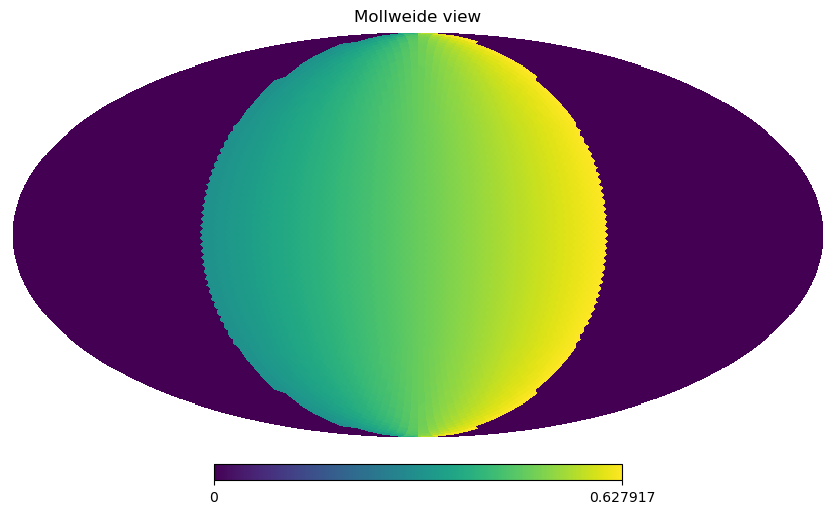

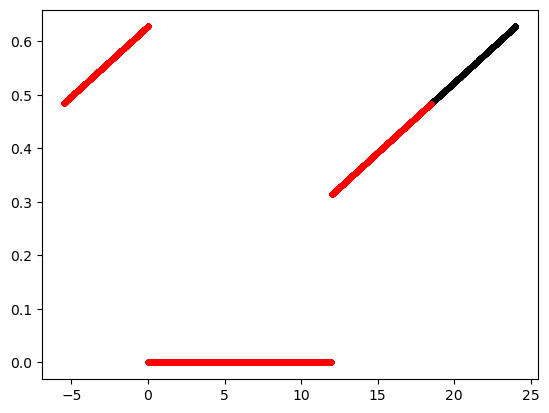

In [34]:
from rubin_scheduler.scheduler import basis_functions
from rubin_scheduler.scheduler import features



rising_bf = basis_functions.RewardRisingBasisFunction(slope=0.1)
val = rising_bf._calc_value(conditions)
hp.mollview(val)
plt.figure()
unwrapped_HA = conditions.HA
oHA = conditions.lmst - np.degrees(conditions.ra) * 24/360
plt.plot(unwrapped_HA * 24/2/np.pi, val, 'k.')
plt.plot(oHA, val, 'r.')

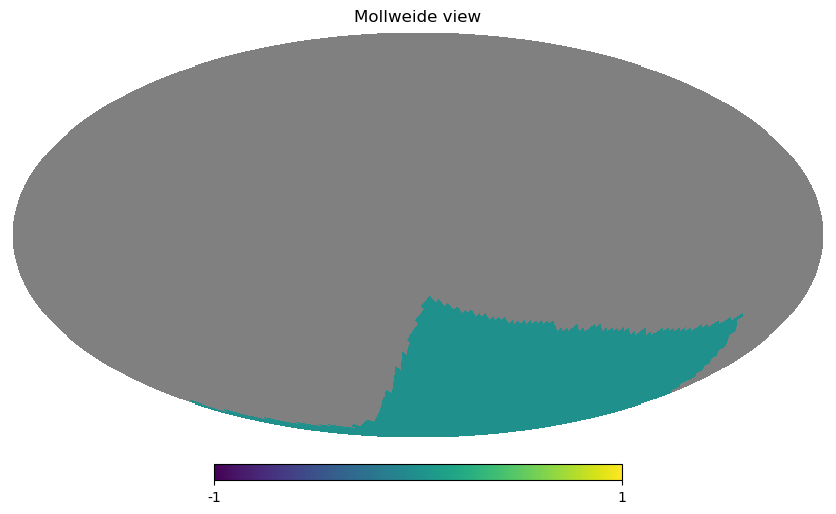

In [35]:
bf = basis_functions.AltAzShadowMaskBasisFunction(min_alt=20, max_alt=85, min_az=100, max_az=250, shadow_minutes=40)
val = bf._calc_value(conditions)
hp.mollview(val)

In [36]:
from rubin_scheduler.scheduler import basis_functions
from rubin_scheduler.scheduler import features
from rubin_scheduler.scheduler.detailers import CameraSmallRotPerObservationListDetailer
from rubin_scheduler.scheduler.utils import IntRounded

def get_fields():
    fields = (
        ("Rubin_SV_095_-25", 95., -25.), # High stellar densty, low extinction
        ("Rubin_SV_125_-15", 125., -15.), # High stellar densty, low extinction
        ("DESI_SV3_R1", 179.60, 0.000), # DESI, GAMA, HSC DR2, KiDS-N
        ("Rubin_SV_225_-40", 225., -40.), # 225 High stellar densty, low extinction
        ("DEEP_A0", 216, -12.5), # DEEP Solar Systen
        ("Rubin_SV_250_2", 250., 2.), # 250 High stellar densty, low extinction
        ("Rubin_SV_300_-41", 300., -41.), # High stellar densty, low extinction 
        ("Rubin_SV_280_-48", 280., -48.), # High stellar densty, low extinction 
        ("DEEP_B0", 310, -19), # DEEP Solar System
        ("ELAIS_S1", 9.45, -44.0), # ELAIS-S1 LSST DDF
        ("XMM_LSS", 35.708333, -4.75), # LSST DDF
        ("ECDFS", 53.125, -28.1), # ECDFS
        ("COSMOS", 150.1, 2.1819444444444445), # COSMOS
        ("EDFS_A", 58.9, -49.315), # EDFS_a
        ("EDFS_B", 63.6, -47.6), # EDFS_b
    )
    
    fields_dict = dict(zip([f[0] for f in fields], [{'RA': f[1], 'Dec': f[2]} for f in fields]))
    return fields_dict


def get_basis_functions_field_survey(
    nside: int = 32,
    wind_speed_maximum: float = 10,
) -> list[basis_functions.BaseBasisFunction]:
    """Get the basis functions for a field survey.

    Parameters
    ----------
    nside : `int`
        The nside value for the healpix grid.
    wind_speed_maximum : `float`
        Maximum wind speed tolerated for the observations of the survey,
        in m/s.

    Returns
    -------
    `list` of `basis_functions.BaseBasisFunction`
    """
    sun_alt_limit = -12.0
    moon_distance = 30

    bfs = [
        basis_functions.NotTwilightBasisFunction(sun_alt_limit=sun_alt_limit),
        basis_functions.MoonAvoidanceBasisFunction(nside=nside, moon_distance=moon_distance),
        basis_functions.AvoidDirectWind(
            wind_speed_maximum=wind_speed_maximum, nside=nside
        ),
        # Mask parts of the sky in alt/az, including parts of the sky that will move into this area
        # (replaces azimuth mask and zenith shadow mask, should also be able to replace airmass basis function)
        basis_functions.AltAzShadowMaskBasisFunction(
            nside=nside, min_alt=20, max_alt=85, min_az=0.0, max_az=360.0, shadow_minutes=50
        ),
        # Avoid revisits within 30 minutes
        basis_functions.AvoidFastRevisitsBasisFunction(nside=nside, filtername=None, gap_min=30.0),
        # reward fields which are rising, but don't mask out after zenith
        basis_functions.RewardRisingBasisFunction(nside=nside, slope=0.1, penalty_val=0),
        # Reward parts of the sky which are darker -- note that this is only for r band, so relying on
        # skymap in r band .. if there isn't a strong reason to go with the darkest pointing,
        # it might be reasonable to just drop this basis function
        #basis_functions.M5DiffBasisFunction(filtername='r', nside=nside),
    ]
    return bfs

def get_field_survey(field_ra_deg, field_dec_deg, field_name, basis_functions, detailers, nside=32):
    
    field_survey = NewFieldSurvey(basis_functions, 
                                   field_ra_deg,
                                    field_dec_deg,
                                    sequence='ugrizy',
                                    nvisits={'u': 20, 'g': 20, 'r': 20, 'i': 20, 'z': 20, 'y': 20},
                                    exptimes={'u': 38, 'g': 30, 'r': 30, 'i': 30, 'z': 30, 'y': 30},
                                    nexps={'u': 1, 'g': 2, 'r': 2, 'i': 2, 'z': 2, 'y': 2},
                                    ignore_obs=None,
                                    accept_obs=None,
                                    survey_name=field_name,
                                    scheduler_note=None,
                                    readtime=2.4,
                                    filter_change_time=120.0,
                                    nside=nside,
                                    flush_pad=30.0,
                                    detailers=detailers)
    return field_survey

In [41]:
bf = get_basis_functions_field_survey()
# To check what these basis functions "look like" ... 
# (note that once they are tied to a particular survey, the 
# SURVEY will know how to use only the relevant healpix value)
for b in bf:
    print(b.label(), "feasible? ", b.check_feasibility(conditions), b(conditions))

detailer = CameraSmallRotPerObservationListDetailer(per_visit_rot=0.5)

field_dict = get_fields()

print("Check each of these field surveys at the time of conditions")
print(observatory.mjd)

fsurveys = {}
for k in field_dict:
    fsurveys[k] = get_field_survey(field_dict[k]['RA'], field_dict[k]['Dec'], k, bf, [detailer])
    reward = fsurveys[k].calc_reward_function(conditions)
    print(k, reward)

NotTwilight @6984875920 feasible?  True 0
MoonAvoidance @6984811664 feasible?  True [1. 1. 1. ... 1. 1. 1.]
AvoidDirectWind @6984817232 feasible?  True [-15.00377567 -13.96963326 -13.85740505 ... -14.87204524 -15.00377567
 -13.96963326]
AltAzShadowMask @6984813968 feasible?  True [nan nan nan ...  0.  0.  0.]
AvoidFastRevisits @6984825808 feasible?  True [1. 1. 1. ... 1. 1. 1.]
RewardRising @6984424848 feasible?  True [0.40456975 0.         0.         ... 0.         0.         0.56164939]
Check each of these field surveys at the time of conditions
60562.99454106344
Rubin_SV_095_-25 nan
Rubin_SV_125_-15 nan
DESI_SV3_R1 nan
Rubin_SV_225_-40 nan
DEEP_A0 nan
Rubin_SV_250_2 nan
Rubin_SV_300_-41 0.2597217159544778
Rubin_SV_280_-48 -1.4446906899733378
DEEP_B0 -2.3202576566427795
ELAIS_S1 nan
XMM_LSS nan
ECDFS nan
COSMOS nan
EDFS_A nan
EDFS_B nan


In [44]:
from rubin_scheduler.scheduler.schedulers import CoreScheduler

def prioritize_fields(priority_field_list=None, other_field_list=None):
    field_dict = get_fields()
    tier1 = []
    if priority_field_list is not None:
        for f in priority_field_list:
            # Remember field name and remove from list
            if f in field_dict:
                tier1.append(f)
                del field_dict[f]
    tier2 = []
    if other_field_list is not None:
        for f in other_field_list:
            if f in field_dict:
                tier2.append(f)
                del field_dict[f]
    else:
        tier2 += list(field_dict.keys())
    return [tier1, tier2]


tiers = prioritize_fields(['Rubin_SV_280_-48'], None)

print(tiers)

[['Rubin_SV_280_-48'], ['Rubin_SV_095_-25', 'Rubin_SV_125_-15', 'DESI_SV3_R1', 'Rubin_SV_225_-40', 'DEEP_A0', 'Rubin_SV_250_2', 'Rubin_SV_300_-41', 'DEEP_B0', 'ELAIS_S1', 'XMM_LSS', 'ECDFS', 'COSMOS', 'EDFS_A', 'EDFS_B']]


In [48]:
surveys = []
starting_tier = 0
for i, t in enumerate(tiers):
    j = i + starting_tier
    surveys
    for kk, fieldname in enumerate(t):
        bfs = get_basis_functions_field_survey()
        detailer = CameraSmallRotPerObservationListDetailer(per_visit_rot=0.5)
        surveys[j][kk] = get_field_survey(field_dict[fieldname]['RA'], field_dict[fieldname]['Dec'], fieldname, bfs, [detailer])
surveys

IndexError: list assignment index out of range

In [18]:
# Doesn't look right yet .. 
scheduler.survey_lists

[[<NewFieldSurvey survey_name='Rubin_SV_095_-25', RA=1.6580627893946132, dec=-0.4363323129985824 at 0x1a99a9610>,
  <NewFieldSurvey survey_name='Rubin_SV_125_-15', RA=2.181661564992912, dec=-0.2617993877991494 at 0x1a995fe50>,
  <NewFieldSurvey survey_name='DESI_SV3_R1', RA=3.134611336581816, dec=0.0 at 0x1a98ba650>,
  <NewFieldSurvey survey_name='Rubin_SV_225_-40', RA=3.9269908169872414, dec=-0.6981317007977318 at 0x1a98c6cd0>,
  <NewFieldSurvey survey_name='DEEP_A0', RA=3.7699111843077517, dec=-0.2181661564992912 at 0x1a997d110>,
  <NewFieldSurvey survey_name='Rubin_SV_250_2', RA=4.363323129985824, dec=0.03490658503988659 at 0x1a9963550>,
  <NewFieldSurvey survey_name='Rubin_SV_300_-41', RA=5.235987755982989, dec=-0.7155849933176751 at 0x1a98ab290>,
  <NewFieldSurvey survey_name='Rubin_SV_280_-48', RA=4.886921905584122, dec=-0.8377580409572782 at 0x1a95da910>,
  <NewFieldSurvey survey_name='DEEP_B0', RA=5.410520681182422, dec=-0.33161255787892263 at 0x1a99b35d0>,
  <NewFieldSurvey su

In [19]:
import copy
from rubin_scheduler.scheduler.schedulers import ComCamFilterSched
from rubin_scheduler.scheduler import sim_runner

In [ ]:
!ls

In [ ]:
# Note the deep copy used here. The function sim_runner modifies the observatory
# Change the date of what is RUNNING (what night) by changing time in the observatory
# Leave the start of the observatory running at survey_start
new_mo, new_scheduler, observations = sim_runner(copy.deepcopy(observatory), copy.deepcopy(scheduler), 
                                                 filter_scheduler=ComCamFilterSched(),
                                                 mjd_start=survey_start.mjd,
                                                 survey_length=1, verbose=False)
del new_mo
del new_scheduler

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:338: UserWarning: Sun high, using bright sky approx
  warnings.warn("Sun high, using bright sky approx")
Failed to fill queue at time 60562.5
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:116: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time 60562.510416666664
Failed to fill queue at time 60562.52083333333
Failed to fill queue at time 60562.53124999999
Failed to fill queue at time 60562.54166666666
Failed to fill queue at time 60562.55208333332
Failed to fill queue at time 60562.562499999985
Failed to fill queue at time 60562.57291666665
Failed to fill queue at time 60562.583333333314
Failed to fill queue at time 60562.59374999998
Failed to fill queue at time 60562.60416666664
Failed to fill queue at time 60562.61458333331
Failed to fill que

In [ ]:
scheduler.survey_lists[0][0].roi_hpid, scheduler.survey_lists[0][0].survey_name

In [ ]:
from rubin_scheduler.scheduler.utils import SchemaConverter

In [ ]:
sc = SchemaConverter()
visits = sc.obs2opsim(observations)

In [ ]:
visits.head()

In [ ]:
import rubin_sim.maf as maf

In [ ]:
m = maf.CountMetric(col='observationStartMJD')
s = maf.HealpixSlicer(64)
bundle = maf.MetricBundle(m, s, "")

visits_np = visits.to_records()  # MAF does need a np.ndarray
out_dir='test'
g = maf.MetricBundleGroup({'0': bundle}, None, out_dir=out_dir)
g.run_current('', sim_data=visits_np)

In [ ]:
bundle.plot()

In [ ]:
visits.groupby('target')['observationStartMJD'].count()

In [ ]:
plt.figure()
filtershapes = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}
filtercolors = {'u': '#005BDB',
                'g': '#3DA952',
                'r': '#c61c00',
                'i': '#997500',
                'z': '#CE0D77',
                'y': '#5d0000'}
fieldcolors = {}
for i, t in enumerate(visits.target.unique()):
    fieldcolors[t] = cc.glasbey[i]

nvisits = visits.query('night ==2')
for t in nvisits.target.unique():
    vv = nvisits.query('target == @t')
    for f in 'ugrizy':
        vvf = vv.query('filter == @f')
        label = f'{t} {f}'
        plt.plot(vvf.observationStartMJD, vvf.airmass, linestyle='', 
                 marker=filtershapes[f], markersize=3, color=fieldcolors[t], label=label)
plt.legend(loc=(1.01,0.01), ncols=3)
plt.ylim(2.5, 0.9)
plt.grid(alpha=0.3)

In [ ]:
visits['filter'].unique()